# Data collapse

In [14]:
import os
import glob
import pickle
# Our numerical workhorses
import numpy as np
import pandas as pd
import scipy
import numdifftools as ndt # to comput the Hessian matrix

import mwc_induction_utils as mwc

# Import matplotlib stuff for plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Seaborn, useful for graphics
import seaborn as sns

# favorite Seaborn settings for notebooks
rc={'lines.linewidth': 2, 
    'axes.labelsize' : 16, 
    'axes.titlesize' : 18,
    'axes.facecolor' : 'F4F3F6',
    'axes.edgecolor' : '000000',
    'axes.linewidth' : 1.2,
    'xtick.labelsize' : 13,
    'ytick.labelsize' : 13,
    'grid.linestyle' : ':',
    'grid.color' : 'a6a6a6'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)
sns.set_palette("deep", color_codes=True)

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline (only use with static plots (non-Bokeh))
%config InlineBackend.figure_format = 'svg'

## The Bohr parameter.

For the *lac* repressor we know that the fold-change in gene expression is given by

\begin{align}
\text{fold-change}(C) = \left( 1 + \frac{2R}{N_{NS}} \cdot p_{act}(C) \cdot e^{-\beta \Delta \epsilon_r} \right)^{-1},
\end{align}

where $R$ is the number of repressors, $N_{NS}$ is the number of non-specific sites to which the repressor can bind, $\Delta \epsilon_r$ is the binding energy of the repressor to the DNA binding site, $\beta$ is the inverse Boltzmann constant times the temperature, and $p_{act}$ is the probability of the repressor being active given a concentration of inducer $C$.

The functional form of this $p_{act}$ is given by the MWC model as

\begin{equation}
p_{act}(C) = \frac{\left( 1 + \frac{C}{K_A} \right)^2}{\left( 1 + \frac{C}{K_A} \right)^2 + e^{-\beta \Delta \epsilon_{ai}}\left( 1 + \frac{C}{K_I} \right)^2},
\end{equation}

where $K_A$ and $K_I$ are the dissociation constants of the repressor in the active and inactive state respectively and $\Delta \epsilon$ is the energetic difference between these two states. For the specific case of the *lac* repressor we have that $K_A \geq K_I$ and $\Delta \epsilon_{ai} \geq 0$.

To isolate the effect of the thermodynamic parameters we can re-write the fold-change equation as a Fermi potential, i.e.

\begin{equation}
\text{fold-change} = \frac{1}{1 + e^{-\beta F(C)}},
\end{equation}

where we have introduced the *Bohr parameter*,

\begin{equation}
F(C) \equiv -k_BT \log \left( \frac{\left( 1 + \frac{C}{K_A} \right)^2}{\left( 1 + \frac{C}{K_A} \right)^2 + e^{-\beta \Delta \epsilon_{ai}}\left( 1 + \frac{C}{K_I} \right)^2} \cdot \frac{2R}{N_{NS}}e^{-\beta \Delta \epsilon_r} \right).
\end{equation}

Let's first load all of the data sets.

In [12]:
datadir = '../../data/'
# read the list of data-sets to ignore
data_ignore = pd.read_csv(datadir + 'datasets_ignore.csv', header=None).values
# read the all data sets except for the ones in the ignore list
all_files = glob.glob(datadir + '*' + '_IPTG_titration' + '*csv')
ignore_files = [f for f in all_files for i in data_ignore if i[0] in f]
read_files = [f for f in all_files if f not in ignore_files]
print('Number of independent data-sets: {:d}'.format(len(read_files)))
df = pd.concat(pd.read_csv(f, comment='#') for f in read_files)

# Now we remove the autofluorescence and delta values
df = df[(df.rbs != 'auto') & (df.rbs != 'delta')]

df.head()

Number of independent data-sets: 13


,date,username,operator,binding_energy,rbs,repressors,IPTG_uM,mean_YFP_A,mean_YFP_bgcorr_A,fold_change_A
2,20160804,mrazomej,O2,-13.9,RBS1L,870,0.0,3624.474605,111.851286,0.007146
3,20160804,mrazomej,O2,-13.9,RBS1,610,0.0,3619.786265,107.162946,0.006847
4,20160804,mrazomej,O2,-13.9,RBS1027,130,0.0,3717.019527,204.396208,0.013059
5,20160804,mrazomej,O2,-13.9,RBS446,62,0.0,3854.650585,342.027265,0.021853
6,20160804,mrazomej,O2,-13.9,RBS1147,30,0.0,4169.802851,657.179531,0.041988


The values for the parameters we will use were determined [using MCMC](https://github.com/RPGroup-PBoC/mwc_induction/blob/master/code/analysis/MCMC_parameter_estimation.ipynb) over all the O2 data sets, except for the HG104 strain.

In [15]:
# Parameters obtained using MCMC
# Load the data
with open('../../data/mcmc/' + '20160815' + \
                  '_gauss_homoscedastic_pool_data.pkl', 'rb') as file:
    unpickler = pickle.Unpickler(file)
    gauss_pool_flatchain = unpickler.load()
    
# map value of the parameters
ea, ei = np.mean(gauss_pool_flatchain[:, [0, 1]], axis=0)
# ea range
ea_hpd = mwc.hpd(gauss_pool_flatchain[:, 0], 0.95)
ei_hpd = mwc.hpd(gauss_pool_flatchain[:, 1], 0.95)

Now let's define a function that takes a tidy `DataFrame` and computes the Bohr parameter.

In [17]:
def bohr_fn(df, ea, ei, epsilon=4.5):
    '''
    Computes the Bohr parameter for the data in a DataFrame df as a function
    of the MWC parameters ea and ei
    Parameters
    ----------
    df : DataFrame
        Pandas DataFrame containing all the data for which to calculate the bohr
        parameter
    ea, ei : float.
        Minus log of the dissociation constants of the active and the inactive 
        states respectively.
    epsilon : float.
        energy difference between the active and the inactive state.
    
    Returns
    -------
    bohr : array-like.
        Array with all the calculated Bohr parameters.
    '''
    bohr_param = []
    for i in range(len(df)):
        pact = mwc.pact_log(IPTG=df.iloc[i].IPTG_uM, ea=ea, ei=ei,
                            epsilon=epsilon)
        F = -np.log(2 * df.iloc[i].repressors / 4.6E6 * pact * \
                (1 + np.exp(-4.5)) * np.exp(-df.iloc[i].binding_energy))
        bohr_param.append(F)
    return bohr_param

In [18]:
df['bohr_param'] = bohr_fn(df, ea, ei)

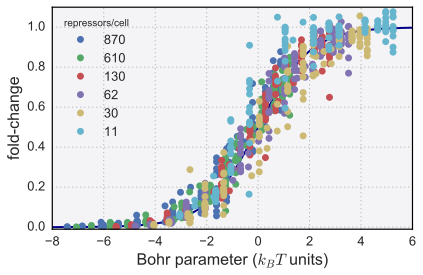

In [23]:
# Given this result let's plot all the curves using this parameters.
colors = sns.color_palette(n_colors=8)
F = np.linspace(-8, 6, 200)
plt.figure()
plt.plot(F, 1 / (1 + np.exp(-F)), '-', color='darkblue')
for i, rbs in enumerate(df.rbs.unique()):
    # plot the experimental data
    plt.plot(df[df.rbs == rbs].sort_values(by='IPTG_uM').bohr_param, 
            df[df.rbs == rbs].sort_values(by='IPTG_uM').fold_change_A, 
            marker='o', linewidth=0,
            label=repressor[i], color=colors[i], alpha=0.7)
plt.xlabel(r'Bohr parameter ($k_BT$ units)')
plt.ylabel('fold-change')
plt.ylim([-0.01, 1.1])
plt.legend(loc='upper left', ncol=1, title='repressors/cell', fontsize=13)
plt.tight_layout()
#plt.savefig('/Users/razo/Desktop/data_collapse.pdf')

Voila, data collapse baby!

## Plot by operator

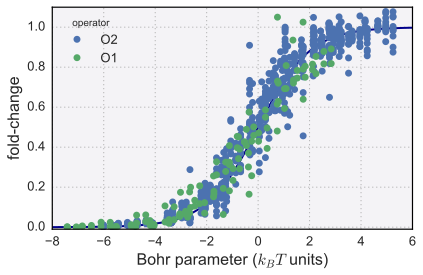

In [26]:
# Given this result let's plot all the curves using this parameters.
colors = sns.color_palette(n_colors=8)
F = np.linspace(-8, 6, 200)
plt.figure()
plt.plot(F, 1 / (1 + np.exp(-F)), '-', color='darkblue')
for i, operator in enumerate(df.operator.unique()):
    # plot the experimental data
    plt.plot(df[df.operator == operator].sort_values(by='IPTG_uM').bohr_param, 
            df[df.operator == operator].sort_values(by='IPTG_uM').fold_change_A, 
            marker='o', linewidth=0,
            label=operator, color=colors[i], alpha=0.7)
plt.xlabel(r'Bohr parameter ($k_BT$ units)')
plt.ylabel('fold-change')
plt.ylim([-0.01, 1.1])
plt.legend(loc='upper left', ncol=1, title='operator', fontsize=13)
plt.tight_layout()
#plt.savefig('/Users/razo/Desktop/data_collapse.pdf')

## Plot by RBS and by operator

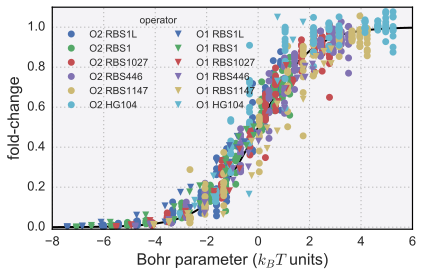

In [31]:
F = np.linspace(-8, 6, 200)

plt.figure()
plt.plot(F, 1 / (1 + np.exp(-F)), '-', color='black')
marker = ['o', 'v']
for i, operator in enumerate(df.operator.unique()):
    for j, rbs in enumerate(df.rbs.unique()):
        # plot the experimental data
        df_plot = df[(df.operator == operator) & (df.rbs == rbs)]
        plt.plot(df_plot.sort_values(by='IPTG_uM').bohr_param, 
                df_plot.sort_values(by='IPTG_uM').fold_change_A, 
                linewidth=0, marker=marker[i],
                label=operator + ' ' + rbs, alpha=0.7)
plt.xlabel(r'Bohr parameter ($k_BT$ units)')
plt.ylabel('fold-change')
plt.ylim([-0.01, 1.1])
plt.legend(loc='upper left', ncol=2, title='operator')
plt.tight_layout()